# **Classic Time Series decomposition techniques**
### This notebook is a study deeply based on the book "Makridakis, Wheelwright & Hyndman - Forecasting, Methods and Applications." on chapter 3, (Times Series Decomposition). The objective is apply the described techniques of classical decomposition to anyone who wants a on-hands learning, since this classic techniques, are still important to understand the fundamental aproacch.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
bikes_data = pd.read_csv("/kaggle/input/bike-sales-in-europe/Sales.csv",parse_dates = ["Date"])
bikes_data = bikes_data.set_index("Date").to_period('D').sort_index()


## **What is?**
### The decomposition principle is based on separating the basic three fundamental parts of some kinds of time series data: Trend-cycle, Seasonality, and Random error. According to this definition, randomness is part of the series. However, some definitions might state that the series is formed just by Trend-cycle and Seasonality, with the error component being something aside from the data.

## **Trend-cycle**
### Trend-cycle - It is the combination of two components. The trend is a long-term movement of the series, defining the direction in which the series goes. The cycle is the smooth pattern that follows the trend and represents a pattern of variation, with ups and downs that do not follow a strict date pattern, meaning they are time-independent.

## **Seasonality**
### Seasonality - Time-dependent variation that goes with the trend-cycle. Its occurrence tends to repeat itself on a defined date stamp and can show some variation in its behavior caused by the Trend-cycle. In business and sales analytics, it can represent holidays, production of a product falling due to winter, Christmas, and many other factors.

## **Random error**
### Random error - The true definition of random error can be broader. It can represent outliers or measurement errors and can be visualized as noise in the data, the unpredictable part. It is the difference that remains when you take the trend-cycle and the seasonality out of the data. It's useful to note that this noise can cause a lot of trouble when working on a forecast model.

## **Why decomposition?**
### In data analysis, more than building models and adjusting parameters, visualizing and understanding the data well is crucial to solving real-world problems. From a technical or fundamental approach, information is key to making the right decisions. Decomposition helps to extract information by separating these components. A basic principle to understand is that some kinds of time series can be described as a function like this: data = f(Trend-cycle, Seasonality, error).

# **Visualizing the data**

### **Working with a bike sales date, focusing in the sales quantity, the US is choosed as the country to work with**

In [3]:
bikes_data.head()

,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
Date,,,,,,,,,,,,,,,,,
2011-01-01,1,January,2011,42,Adults (35-64),M,United States,California,Bikes,Road Bikes,"Road-750 Black, 44",1,344,540,185,344,529
2011-01-01,1,January,2011,33,Young Adults (25-34),F,France,Yveline,Bikes,Road Bikes,"Road-150 Red, 48",2,2171,3578,1097,4342,5439
2011-01-01,1,January,2011,17,Youth (<25),M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",1,1519,2443,900,1519,2419
2011-01-01,1,January,2011,39,Adults (35-64),M,United States,Washington,Bikes,Road Bikes,"Road-550-W Yellow, 38",3,713,1120,482,2139,2621
2011-01-01,1,January,2011,23,Youth (<25),M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",1,1252,2295,561,1252,1813


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


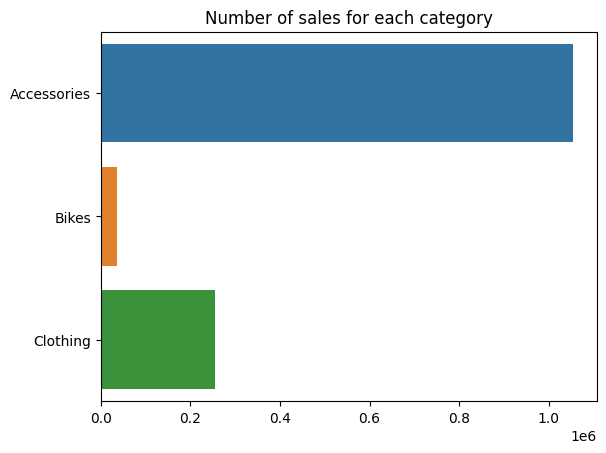

In [4]:
sum_per_category = bikes_data.groupby("Product_Category")["Order_Quantity"].sum()
sum_per_category
categories, values = list(zip(*(sum_per_category.items())))
ax = sns.barplot(y = list(categories) , x = list(values))
ax.set_title('Number of sales for each category')
plt.show()

## Grouping the data of bikes sales for each state, and then, choosing the Bikes sales as target.

In [5]:
sum_bike_per_US_state = bikes_data.loc[(bikes_data["Product_Category"] == "Bikes") & (bikes_data["Country"] == "United States")].groupby(["Date" , "State"])["Order_Quantity"].sum().to_frame()
sum_bike_per_US_state

Order_Quantity
Date       State                     
2011-01-01 California               1
           Washington               3
2011-01-02 California               1
2011-01-03 California               5
2011-01-04 California               2
...                               ...
2016-06-28 Washington              12
2016-06-29 California               8
           Oregon                   3
2016-06-30 California               6
           Washington               1

[3370 rows x 1 columns]

<Axes: >

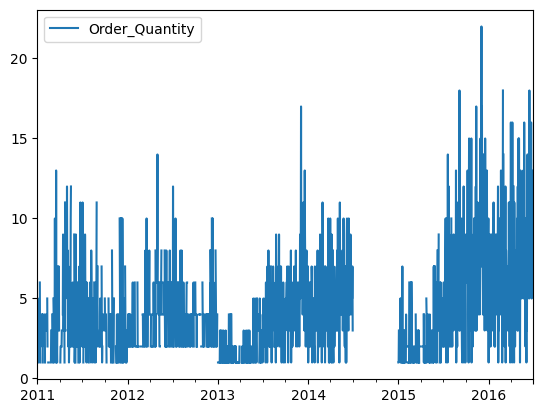

In [6]:
### WITH THE SELECTED STATE, NOW WE HAVE THE ALMOST FINAL FORM OF THE DATA THE WE WILL WORK WITH

choosed_state = "California"
bike_sales = sum_bike_per_US_state.reset_index()
bike_sales = bike_sales.loc[bike_sales["State"] == choosed_state].set_index("Date")

### In this step we try to make sure that all the valid days are available in the data to keep time consistency

complet_index_df = pd.DataFrame(index=pd.period_range(start='2011-01-01', end='2016-06-30', freq='D'))
bike_sales = complet_index_df.join(bike_sales,how = "left")
bike_sales.plot()

## In the previous step, with the completude of the days garanteed, its possible to see that the series has a lot of missing points, so a basicly aproach is combine the interpolation with a moving average to smoothing .

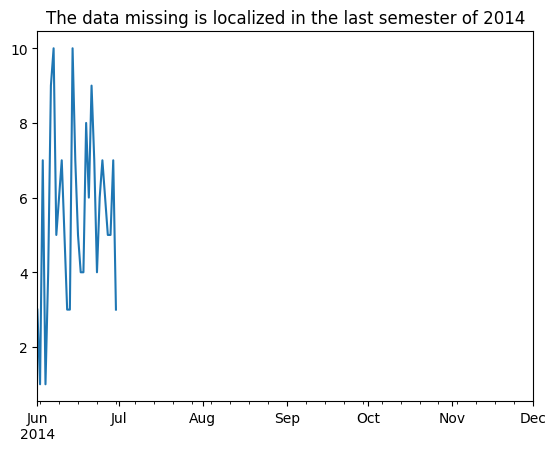

In [7]:
bike_sales.loc["2014-06-01":"2014-12-01","Order_Quantity"].plot()
plt.title("The data missing is localized in the last semester of 2014")
plt.show()

### *For smoothing now the moving average will be used, it transforms the data reducing the high variance in the values that are closer to each other; how much close? Well, it depends on the choosed window size, there is a trade off between losing information and highligntning the desired pattern. Actually the smoothing process is crucial part on the theme of this notebook, where its him the one thas play the role to highlight the trend-cycle to work in the decomposition.*

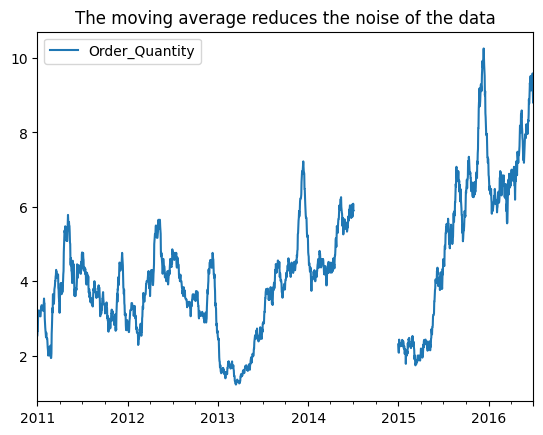

In [8]:
bike_sales["Order_Quantity"].rolling(window = 27,center = True,min_periods = 10).mean().to_frame().plot()
plt.title("The moving average reduces the noise of the data")
plt.show()

## Initially, it appears that the data follows an up-and-down cycle that will match with the interpolation in a satisfactory way. It is never certain, of course, that this gap represents a downward movement, but through the decomposition steps, it will be possible to visualize this more clearly.

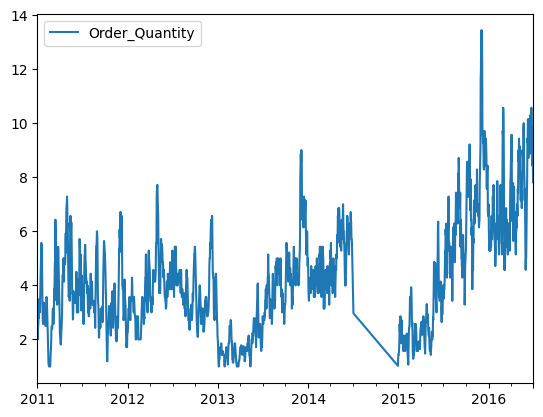

In [9]:
## Filling

index = bike_sales.index
bike_sales["Order_Quantity"] = bike_sales.reset_index()["Order_Quantity"].interpolate(method='polynomial', order=1).rolling(window = 7,center = True,min_periods = 3).mean().values
bike_sales.index = index
bike_sales.plot()
bike_sales_state = bike_sales

## Moving average as a smoothing process, is a fast and simple solution, it reduce the noise and it will be used here in the decompositon process.Bellow are different moving average sizes and their effects on the data. As the window size of the moving average grows, the values in the smaller regions disappear and what is captured is the more global behaviour of the series.

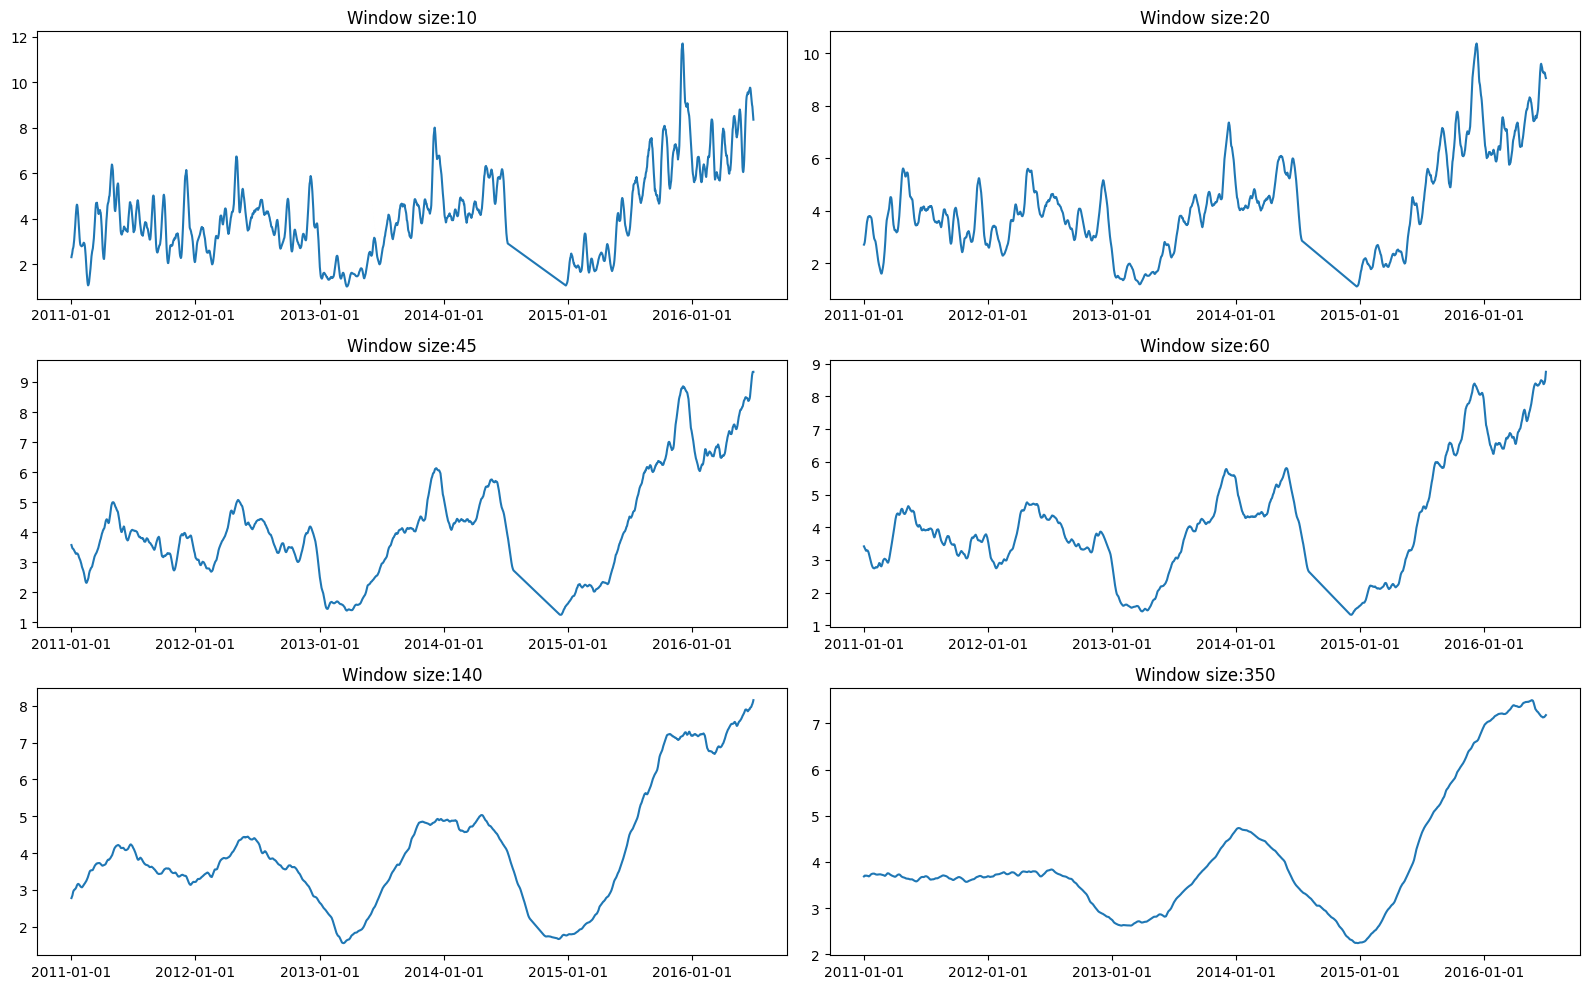

In [10]:
windows_size = [10,20,45,60,140 ,350]

fig, axs = plt.subplots(-(-len(windows_size)//2),2,figsize=(16,10))
for index , window in enumerate(windows_size):
    col = index % 2
    row = int(index/ 2)
    data_to_plot = bike_sales_state["Order_Quantity"].rolling(window = window ,center=True,      
    min_periods=int(window/3),
    ).mean()
    axs[row][col].plot(data_to_plot.index.map(str),data_to_plot )
    axs[row][col].set_title(f"Window size:{window}")
    axs[row][col].set_xticks(["2011-01-01",  "2012-01-01" , "2013-01-01", "2014-01-01","2015-01-01" ,"2016-01-01"])
fig.tight_layout()

## As the window size of the moving average grows, its possible to see the more general behaviour of the series, the trend-cycle.

## **RESAMPLING** - To work in the data set, a month resampling will be the approach to defintly get overral behaviour of the data but most important, to keep all the years of thr set with the same patterns,this will be important soon, cause some months have more days than others and this would become a much more boring task.

/tmp/ipykernel_18/1414327188.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  bike_sales_state = bike_sales_state.resample('M').sum()


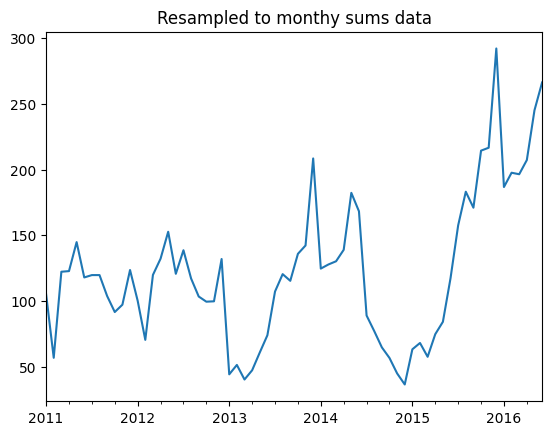

In [11]:
bike_sales_state = bike_sales_state.resample('M').sum()
bike_sales_state["Order_Quantity"].plot()
plt.title("Resampled to monthy sums data")
plt.show()

# **Kinds of decompositions and tranformation**

## Now that we have a better view of the data, we can return to the initial goal: the decomposition of the time series.

### The first thing to notice is that the "order quantity" behavior follows a pattern that repeats itself over a one-year window, with two peeks during the year; this is the seasonality we are looking for. The patterns seem to be missing in the years 2013 and late 2014 to 2015. However, the hypothesis here is that this is the effect of the trend-cycle over the seasonal data. As the trend shifts, the seasonal data gets distorted. To extract the seasonality from the data, we will first obtain the trend-cycle.

In [12]:
def triangular_window(N):
    return 1 - np.abs(np.arange(N) - (N - 1) / 2) / ((N - 1) / 2)

def moving_average_with_window(data,window_size = 5):
    half_window = window_size // 2
    smoothed_data = np.full(data.shape, np.nan) 
    for i in range(0,data.size):
        lf_index = max(0,i - half_window )
        rg_index = min(data.size - 1, i + half_window)
#         print(lf_index)
#         print(rg_index)
#         print(f"<- : {(half_window -(i -lf_index) )}")
#         print(f"-> : {(half_window + (rg_index  -i) + 1)}")
        w_window = triangular_window(window_size)[(half_window -(i -lf_index) ) : (half_window + (rg_index -i) + 1)]
        
        smoothed_data[i] = np.dot(data[lf_index:rg_index + 1], w_window / w_window.sum())

    return smoothed_data

## To capture the trend-cycle here, the approach used here is a weighted moving average with a triangular window, with a slight adaptation to allow the moving average to work over the ends of the serie.The weigths are stronger in center of the window and weaker in the ends, allowing less important noise around a specific point to be minimized.

<Axes: title={'center': 'Trend-Cycle daily data'}>

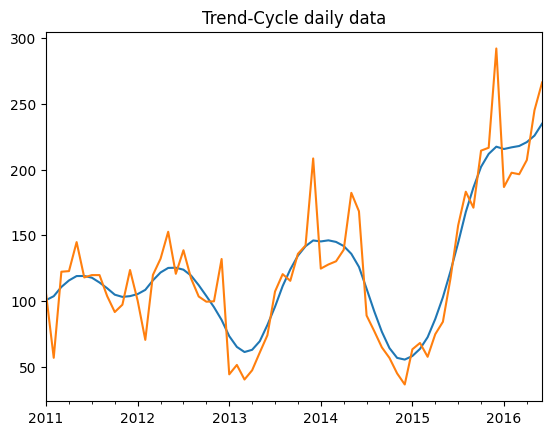

In [13]:

trend_cycle_data = pd.DataFrame()
trend_cycle_data["Order_Quantity"] = moving_average_with_window(bike_sales_state["Order_Quantity"],(11))
trend_cycle_data.index = bike_sales_state.index
plt.title("Trend-Cycle daily data")
trend_cycle_data["Order_Quantity"].plot()
bike_sales_state["Order_Quantity"].plot()

## **Diferents kinds of decomposition**

### **Now that we have the trend-cycle in 'trend_cycle_data' we finally will be able to decompose the series; there are some  slighty diferent approaches to deal with**

###  - The additive decompositon consider the data formed by sum of the componentes, this is better suitable when your series is more *static* so the seasonality dont suffer from high distortion
### - The multiplicative decomposition consider a non static data, it infers that the series is composed by the multiplication of the components
### - The log transformation is basicly a math tricky that has the same use as the multiplicative, but it can help to deal with some extra noise due the transformation, the math explanation is: log(Series) = log(Cycle * Seasonality * error) == log(Series) = log(Cycle) + log(Seasonality) + log(error); so when applying a log tranfomation to a series with multiplicative components, the decomposition can be made by an additive process

## It can be observed bellow that the additive and the multiplicative decomposition, results in basicly the same result, this is caused by the fact the the seasonality dont suffer a high distortion due the trend-cycle, their amplitude its not so affected by movement of the series.

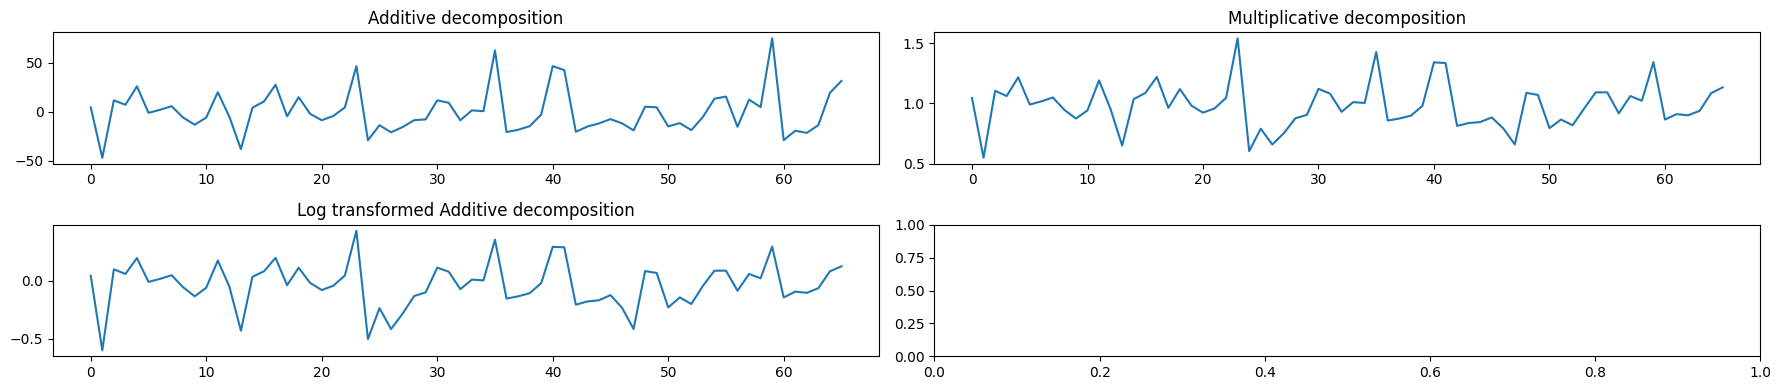

In [14]:
fig , axis = plt.subplots(2,2,figsize = (18,4))

axis[0][0].plot(bike_sales_state["Order_Quantity"].values - trend_cycle_data["Order_Quantity"].values)
axis[0][0].set_title("Additive decomposition")
axis[0][1].plot(bike_sales_state["Order_Quantity"].values / trend_cycle_data["Order_Quantity"].values)
axis[0][1].set_title("Multiplicative decomposition")
axis[1][0].plot(np.log(bike_sales_state["Order_Quantity"].values) - np.log(trend_cycle_data["Order_Quantity"].values))
axis[1][0].set_title("Log transformed Additive decomposition")
# axis[1][1].plot(us_sales_bikes_month["Order_Quantity"].values / trend_cicle_c_month["Order_Quantity"].values) 
plt.tight_layout()

## Getting the seasonal component

### What we have now is the seasonal component with the error component. To extract the seasonal component, we will take the average of the values of the de-trend series for each month over the years. Then, we will use the decomposition approcah to extract from the data, the seasonal averaged component, lefting the resisual only.

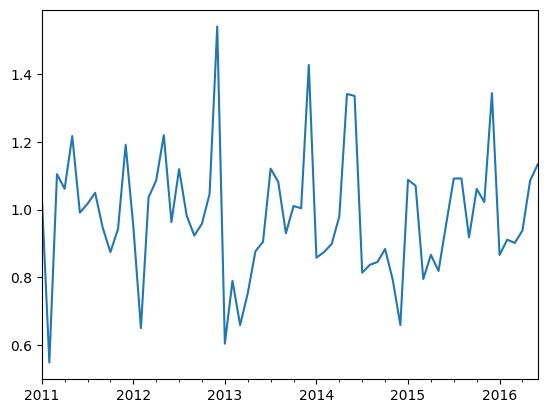

In [15]:
seasonal_with_error = pd.DataFrame(bike_sales_state["Order_Quantity"].values / trend_cycle_data["Order_Quantity"].values,index=bike_sales_state.index)
seasonal_with_error[0].plot()
plt.show()

Text(0.5, 1.0, 'sales during the years')

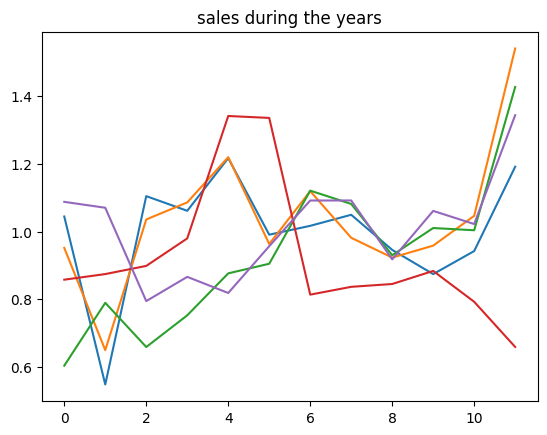

In [16]:
import math
# month_agregade_seasonal_error = seasonal_with_error
seasonal_with_error["year"] = seasonal_with_error.index.year
# month_agregade_seasonal_error.dropna(inplace = True)
# month_agregade_seasonal_error
data_calc = seasonal_with_error.loc[seasonal_with_error["year"] == 2011][0].values
plt.plot(data_calc)
for year in [2012,2013,2014,2015]:

    val = seasonal_with_error.loc[seasonal_with_error["year"] == year][0].values
    plt.plot(val)

#     if pd.isna(val[0]):
#         print(val)
    data_calc = data_calc + val
data_calc = data_calc / 5
plt.title("sales during the years")

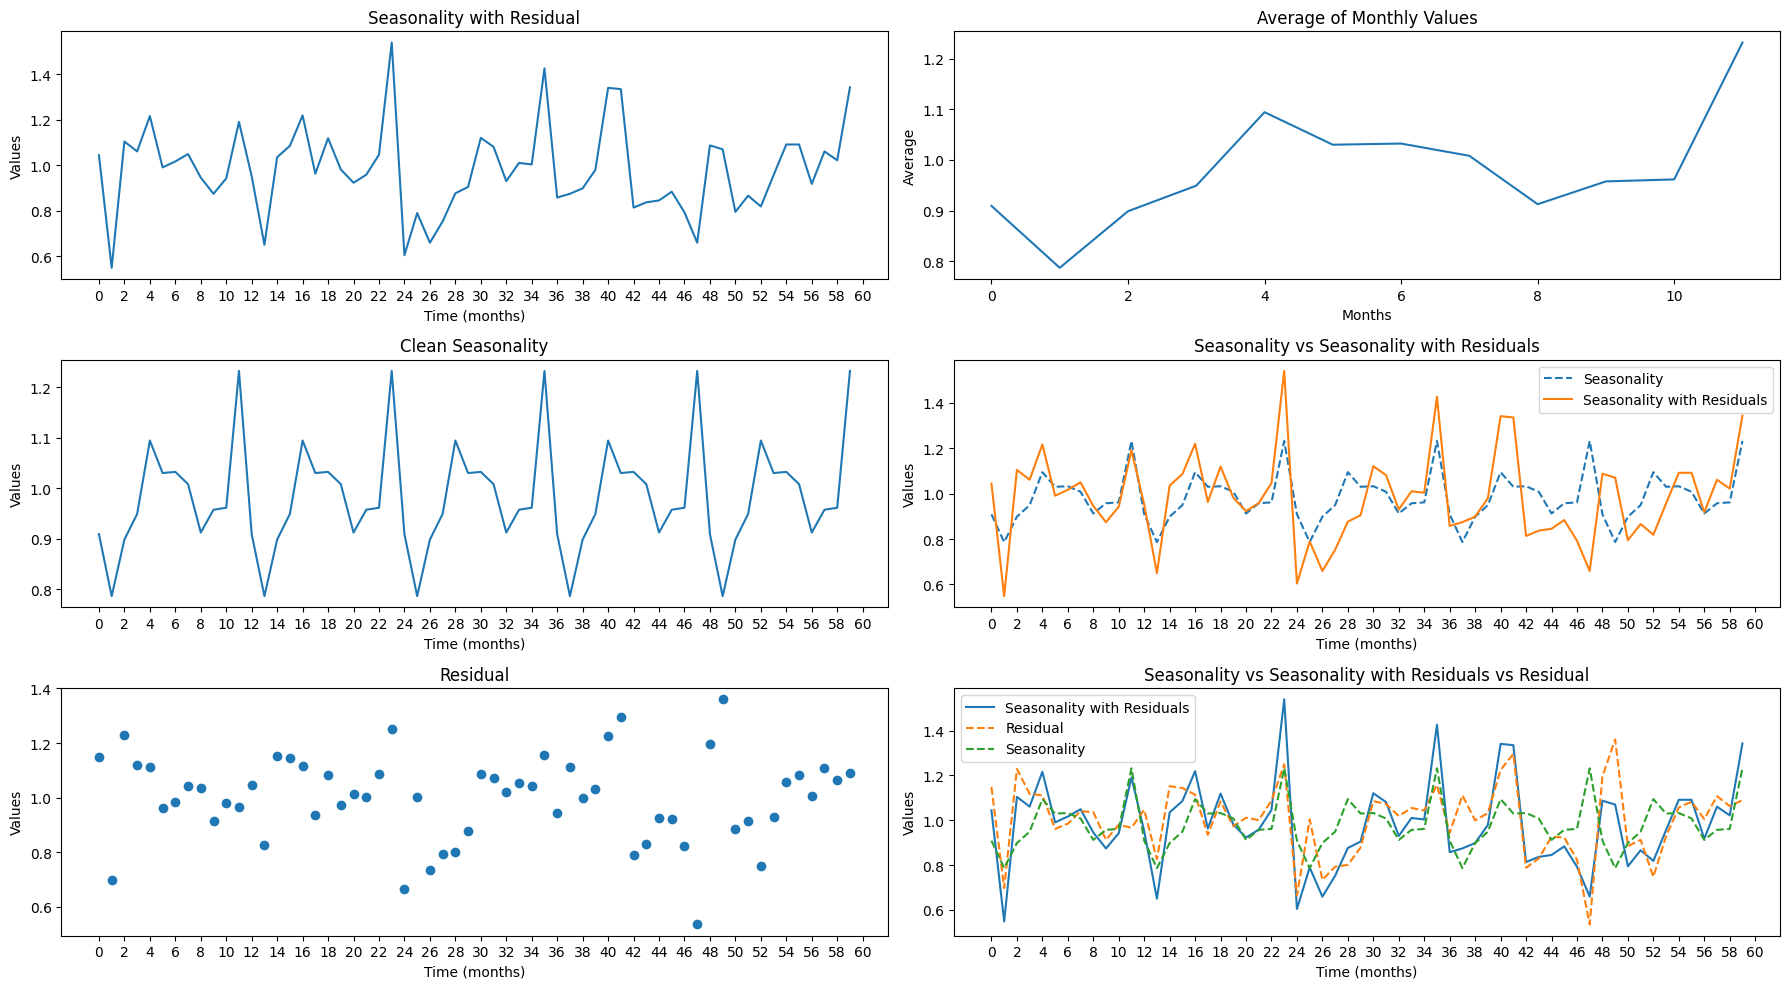

In [17]:
sesonal_data = pd.concat([pd.DataFrame(data_calc)]* 5, ignore_index=True)[0].values
residual = pd.DataFrame(seasonal_with_error.loc["2011-01":"2015-12",0].values / sesonal_data)

fig,axs = plt.subplots(3,2,figsize = (18,10))

seasonal_with_error = seasonal_with_error.loc[seasonal_with_error["year"] != 2016]

index_general = [e for e in range(0,60)]
axs[0][0].plot(index_general, seasonal_with_error[0])
axs[0][0].set_title("Seasonality with Residual")
axs[0][0].set_xlabel("Time (months)")
axs[0][0].set_ylabel("Values")

# Plot 2: Average of monthly values
axs[0][1].plot([e for e in range(0, 12)], data_calc)
axs[0][1].set_title("Average of Monthly Values")
axs[0][1].set_xlabel("Months")
axs[0][1].set_ylabel("Average")

# Plot 3: Clean Seasonality
axs[1][0].plot(index_general, sesonal_data)
axs[1][0].set_title("Clean Seasonality")
axs[1][0].set_xlabel("Time (months)")
axs[1][0].set_ylabel("Values")

# Plot 4: Seasonality vs Seasonality with Residuals
axs[1][1].plot(index_general, sesonal_data, label="Seasonality" ,linestyle='--')
axs[1][1].plot(index_general, seasonal_with_error[0], label="Seasonality with Residuals")
axs[1][1].set_title("Seasonality vs Seasonality with Residuals")
axs[1][1].set_xlabel("Time (months)")
axs[1][1].set_ylabel("Values")
axs[1][1].legend()

# Plot 5: Residual
axs[2][0].scatter(index_general, residual)
axs[2][0].set_title("Residual")
axs[2][0].set_xlabel("Time (months)")
axs[2][0].set_ylabel("Values")

# Plot 6: Seasonality vs Seasonality with Residuals vs Residual
axs[2][1].plot(index_general, seasonal_with_error[0], label="Seasonality with Residuals")
axs[2][1].plot(index_general, residual, label="Residual", linestyle='--')
axs[2][1].plot(index_general, sesonal_data, label="Seasonality",linestyle='--')
axs[2][1].set_title("Seasonality vs Seasonality with Residuals vs Residual")
axs[2][1].set_xlabel("Time (months)")
axs[2][1].set_ylabel("Values")
axs[2][1].legend()

xticks = list(range(0, 61, 2))  # Define os xticks como você desejar
for i ,ax in enumerate(axs.flat):
    if(i != 1):
        ax.set_xticks(xticks)
plt.tight_layout()
plt.show()

## The seasonal behavior of the series shows two peaks within the year: one in May and another in November. One possible explanation for this pattern is that November is close to Christmas, and May coincides with Mother's Day. Both periods are significant gift-giving seasons, which generally lead to an increase in sales across the market. This observation is consistent with typical consumer behavior during these times of the year

#### **Comment below if you see any errors in this notebook. Upvote and Thanks.**